<a href="https://colab.research.google.com/github/praveenpoluri/CS5590-0004/blob/master/icp8/L_6_Encrypted_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section: Encrypted Deep Learning


# Encrypted Computations in PySyft

In [0]:
import syft as sy
import torch as th
from torch import nn, optim

hook = sy.TorchHook(th)

W0711 21:44:38.286935 140259911964544 hook.py:98] Torch was already hooked... skipping hooking process


In [0]:
bob = sy.VirtualWorker(hook, id="bob").add_worker(sy.local_worker)
alice = sy.VirtualWorker(hook, id="alice").add_worker(sy.local_worker)
secure_worker = sy.VirtualWorker(hook, id="secure_worker").add_worker(sy.local_worker)

In [0]:
x = th.tensor([1,2,3,4])
y = th.tensor([2,-1,1,0])

In [0]:
# we assigned one of the parties, secure_worker, to generate the random numbers 
# we have trust that the secure_worker, one of the parties, does not know Alice or Bob (they also do not know each other)
# use the parameter crypto_provider to assign on of the parties

x = x.share(bob, alice, crypto_provider=secure_worker)

In [0]:
y = y.share(bob, alice, crypto_provider=secure_worker) # notice the number of the parties where the secrete is shared

In [0]:
bob._objects

{5832710301: tensor([1942124677794672934, 1386511262076046253, 1864651451166692784,
         2923358307548933517]),
 37155951963: tensor([1024298226974157009, 3757621307906408434, 3212090408686283635,
          585039451028585162])}

We have shared two secretes with three parties. Let's try some computations remotely on these secretes:

In [0]:
# adding secretes on remote machines
z = x + y
z.get() # returns and decodes

tensor([3, 1, 4, 4])

In [0]:
# subtracting secretes on remote machines

z = x - y
z.get()

tensor([-1,  3,  2,  4])

In [0]:
# multiplying secretes on remote machines

z = x * y
z.get()

tensor([ 2, -2,  3,  0])

In [0]:
# boolean operations on remote machines
z = x > y
z.get()

tensor([0, 1, 1, 1])

In [0]:
z = x < y
z.get()

tensor([1, 0, 0, 0])

In [0]:
z = x == y
z.get()

tensor([0, 0, 0, 0])

In [0]:
# double check that your implementation is using the fix_precision() function when dealing with float values
# reverse this function using the float_precision() function

x = th.tensor([1.2, 2.2, 3.2, 4.2])
y = th.tensor([2.1, -1.1, 1.1, 0.1])

x = x.fix_precision().share(bob, alice, crypto_provider=secure_worker)
y = y.fix_precision().share(bob, alice, crypto_provider=secure_worker)

In [0]:
z = x + y
z.get().float_precision()

tensor([3.3000, 1.1000, 4.3000, 4.3000])

In [0]:
z = x - y
z.get().float_precision()

tensor([-0.9000,  3.3000,  2.1000,  4.1000])

In [0]:
z = x * y
z.get().float_precision()

tensor([ 2.5200, -2.4200,  3.5200,  0.4200])

In [0]:
z = x > y
z.get().float_precision()

tensor([0., 1., 1., 1.])

In [0]:
z = x < y
z.get().float_precision()

tensor([1., 0., 0., 0.])

In [0]:
z = x == x
z.get().float_precision()

tensor([1., 1., 1., 1.])

# Lesson: Encrypted Deep Learning in PyTorch

### Build your algorithms and Model

In [0]:
from torch import nn
from torch import optim
import torch.nn.functional as F

# A Toy Dataset
data = th.tensor([[0,0],[0,1],[1,0],[1,1.]], requires_grad=True)
target = th.tensor([[0],[0],[1],[1.]], requires_grad=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x



def train():
    # Training Logic
    opt = optim.SGD(params=model.parameters(), lr=0.1)
    for iter in range(20):

        # 1) erase previous gradients (if they exist)
        opt.zero_grad()

        # 2) make a prediction
        pred = model(data)

        # 3) calculate how much we missed
        loss = ((pred - target)**2).sum()

        # 4) figure out which weights caused us to miss
        loss.backward()

        # 5) change those weights
        opt.step()

        # 6) print our progress
        print(loss.data)
        


In [0]:
model = Net()

#train the model
train()

tensor(2.1571)
tensor(12.9535)
tensor(21.6353)
tensor(1.1473)
tensor(0.9781)
tensor(0.9570)
tensor(0.9398)
tensor(0.9207)
tensor(0.8990)
tensor(0.8741)
tensor(0.8455)
tensor(0.8128)
tensor(0.7757)
tensor(0.7359)
tensor(0.6929)
tensor(0.6448)
tensor(0.5935)
tensor(0.5378)
tensor(0.4791)
tensor(0.4152)


In [0]:
# run predictions
model(data)

tensor([[0.1881],
        [0.4219],
        [0.8541],
        [0.6796]], grad_fn=<AddmmBackward>)

## Encrypt the Model and Data

In [0]:
encrypted_model = model.fix_precision().share(alice, bob, crypto_provider=secure_worker)
encrypted_model

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

In [0]:
list(encrypted_model.parameters())

[Parameter containing:
 Parameter>AutogradTensor>FixedPrecisionTensor>(Wrapper)>[AdditiveSharingTensor]
 	-> (Wrapper)>[PointerTensor | me:5747582235 -> bob:22955187796]
 	-> (Wrapper)>[PointerTensor | me:70178304243 -> alice:68052171563]
 	*crypto provider: secure_worker*, Parameter containing:
 Parameter>AutogradTensor>FixedPrecisionTensor>(Wrapper)>[AdditiveSharingTensor]
 	-> (Wrapper)>[PointerTensor | me:43107561652 -> bob:71961852178]
 	-> (Wrapper)>[PointerTensor | me:86414278975 -> alice:68762703899]
 	*crypto provider: secure_worker*, Parameter containing:
 Parameter>AutogradTensor>FixedPrecisionTensor>(Wrapper)>[AdditiveSharingTensor]
 	-> (Wrapper)>[PointerTensor | me:50688519605 -> bob:86048180237]
 	-> (Wrapper)>[PointerTensor | me:55780423456 -> alice:63836427461]
 	*crypto provider: secure_worker*, Parameter containing:
 Parameter>AutogradTensor>FixedPrecisionTensor>(Wrapper)>[AdditiveSharingTensor]
 	-> (Wrapper)>[PointerTensor | me:23107485845 -> bob:14352544615]
 	-> 

In [0]:
encrypted_data = data.fix_precision().share(alice, bob, crypto_provider=secure_worker)

In [0]:
encrypted_prediction = encrypted_model(encrypted_data)

In [0]:
encrypted_prediction.get().float_precision()

tensor([[0.1870],
        [0.4210],
        [0.8530],
        [0.6780]])

# Reuse the MNIST NN from the previous classes (firs week of classes) to train the classifier with a Secure Federated learning appraoch.

In [0]:

!pip install syft

     |████████████████████████████████| 225kB 5.0MB/s 
     |████████████████████████████████| 389kB 46.3MB/s 
     |████████████████████████████████| 204kB 44.2MB/s 
     |████████████████████████████████| 1.4MB 48.7MB/s 
     |████████████████████████████████| 450kB 48.1MB/s 
     |████████████████████████████████| 81kB 25.9MB/s 
     |████████████████████████████████| 256kB 42.6MB/s 
     |████████████████████████████████| 51kB 16.6MB/s 
     |████████████████████████████████| 276kB 45.1MB/s 
     |████████████████████████████████| 122kB 40.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/ad/9a/f4/3105b5209674ac77fcca7fede95184c62a95df0196888e0e76
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built zstd pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: msgpack 0.5.6
    Uninstalling msgpack-0.5.6:
     

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import helper

In [0]:

import syft as sy
import torch as th
from torch import nn, optim

hook = sy.TorchHook(th)

W0715 05:44:41.251134 140389860087680 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0715 05:44:41.268629 140389860087680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
# create a couple workers

bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
crypto_provider = sy.VirtualWorker(hook, id="crypto_provider")

In [0]:
bob.clear_objects()
alice.clear_objects()

<VirtualWorker id:alice #objects:0>

In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 1
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 10
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [0]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

0it [00:00, ?it/s]

26427392it [00:02, 10579162.24it/s]                             


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 71502.16it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 3063989.61it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 26688.69it/s]            


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        model.get() # <-- NEW: get the model back
        if batch_idx % args.log_interval == 0:
            loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(train_loader) * args.batch_size, #batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [0]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:
model = Net().to(device)
# TODO: Define your network architecture here

#model = model.fix_precision().share(bob, alice, crypto_provider=crypto_provider,  requires_grad=True)

optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

Train Epoch: 1 [0/60032 (0%)]	Loss: 2.308013
Train Epoch: 1 [640/60032 (1%)]	Loss: 2.278277
Train Epoch: 1 [1280/60032 (2%)]	Loss: 2.223066
Train Epoch: 1 [1920/60032 (3%)]	Loss: 2.178230
Train Epoch: 1 [2560/60032 (4%)]	Loss: 2.119330
Train Epoch: 1 [3200/60032 (5%)]	Loss: 1.991134
Train Epoch: 1 [3840/60032 (6%)]	Loss: 1.848124
Train Epoch: 1 [4480/60032 (7%)]	Loss: 1.717725
Train Epoch: 1 [5120/60032 (9%)]	Loss: 1.529551
Train Epoch: 1 [5760/60032 (10%)]	Loss: 1.483605
Train Epoch: 1 [6400/60032 (11%)]	Loss: 1.268205
Train Epoch: 1 [7040/60032 (12%)]	Loss: 1.405404
Train Epoch: 1 [7680/60032 (13%)]	Loss: 1.000153
Train Epoch: 1 [8320/60032 (14%)]	Loss: 1.187712
Train Epoch: 1 [8960/60032 (15%)]	Loss: 1.226823
Train Epoch: 1 [9600/60032 (16%)]	Loss: 1.057866
Train Epoch: 1 [10240/60032 (17%)]	Loss: 0.980531
Train Epoch: 1 [10880/60032 (18%)]	Loss: 0.790167
Train Epoch: 1 [11520/60032 (19%)]	Loss: 0.850935
Train Epoch: 1 [12160/60032 (20%)]	Loss: 0.887532
Train Epoch: 1 [12800/60032 (

In [0]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in federated_train_loader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        # TODO: Training pass
        model.send(images.location)
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        model.get()
        
        running_loss += loss.get().item()
    else:
        print(f"Training loss: {running_loss/len(federated_train_loader)}")

/usr/local/lib/python3.6/dist-packages/syft/workers/base.py:385: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command(*args, **kwargs)


Training loss: 1.3803808731056735
Training loss: 0.7535660138516538
Training loss: 0.6100125259427882
Training loss: 0.5415643302680079
Training loss: 0.505528702474098


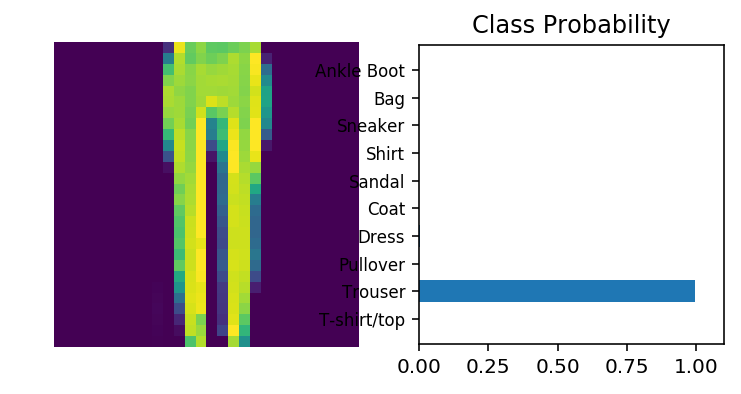

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import helper
import helper

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

# Test out your network!

dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

# Plot the image and probabilities
view_classify(img.resize_(1, 28, 28), ps, version='Fashion')